In [1]:
# Import Keras modules and its important APIs
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import time
import os

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add as addLayer

os.environ['KMP_DUPLICATE_LIB_OK']='True' # This line should prevent kernel death when making graphs.

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Makes one figure able to display multiple pictures
def display_multiple(images, titles, number = 1, rows = 1, cols=1):
    fig = plt.figure(figsize=(10, 10))
    for i in range(number):
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(titles[i])

# All the butterfly-types in the dataset
types = ['Danaus plexippus',
         'Heliconius charitonius',
         'Heliconius erato',
         'Junonia coenia',
         'Lycaena phlaeas',
         'Nymphalis antiopa',
         'Papilio cresphontes',
         'Pieris rapae',
         'Vanessa atalanta',
         'Vanessa cardui']

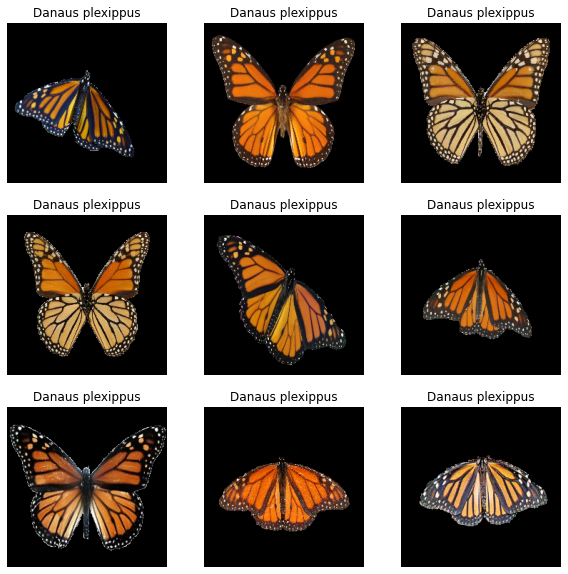

In [3]:
#
# Load data, now with RGB
#

image_data = np.load('./Data/RGB224x224InputImage.npy')
type_name_data = np.load('./Data/RGB224x224OutputType.npy')

# Generate index based on name, as model.fit cannot use string
l = []
for name in type_name_data:
    l.append(types.index(name))
type_index_data = np.asarray(l)

display_multiple(image_data, type_name_data, 9, 3, 3)

In [4]:
#
# Splitting and Preprocessing data
#
subtract_pixel_mean = True

x_train, x_test, y_train, y_test = train_test_split(image_data, type_index_data, test_size=0.33)

x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape[1:])
print(y_train.shape)

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis = 0)
    x_train -= x_train_mean
    x_test -= x_train_mean
 
# Print Training and Test Samples
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
 
classes = np.unique(y_train)
num_classes = len(classes)
num_classes
    
# Convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, num_classes)
#y_test = to_categorical(y_test, num_classes)

(224, 224, 3)
(557,)
x_train shape: (557, 224, 224, 3)
557 train samples
275 test samples
y_train shape: (557,)


10

In [5]:
# Setting Training Hyperparameters
batch_size = 32  # original ResNet paper uses batch_size = 128 for training
epochs = 100
data_augmentation = True
num_classes = 10
 
# Data Preprocessing
n = 3
 
# Select ResNet Version
version = 1
 
# Computed depth of
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
 
# Model name, depth and version
model_type = 'ResNet % dv % d' % (depth, version)
 
# Load the CIFAR-10 data.
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
 
# Input image dimensions.
input_shape = x_train.shape[1:]
 
# Normalize data.
#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255
 


In [6]:
# Setting LR for different number of Epochs
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [7]:
# Basic ResNet Building Block
def resnet_layer(inputs,
                 num_filters = 16,
                 kernel_size = 3,
                 strides = 1,
                 activation ='relu',
                 batch_normalization = True,
                 conv_first = True):
    
    conv = Conv2D(num_filters,
                  kernel_size = kernel_size,
                  strides = strides,
                  padding ='same',
                  kernel_initializer ='he_normal',
                  kernel_regularizer = l2(1e-4))
 
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [8]:
#
def resnet_v1(input_shape, depth, num_classes = 10):
     
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n + 2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
 
    inputs = Input(shape = input_shape)
    x = resnet_layer(inputs = inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs = x,
                             num_filters = num_filters,
                             strides = strides)
            y = resnet_layer(inputs = y,
                             num_filters = num_filters,
                             activation = None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs = x,
                                 num_filters = num_filters,
                                 kernel_size = 1,
                                 strides = strides,
                                 activation = None,
                                 batch_normalization = False)
            x = addLayer([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
 
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size = 8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation ='softmax',
                    kernel_initializer ='he_normal')(y)
 
    # Instantiate model.
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [9]:
# ResNet V2 architecture
def resnet_v2(input_shape, depth, num_classes = 10):
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n + 2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
 
    inputs = Input(shape = input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs = inputs,
                     num_filters = num_filters_in,
                     conv_first = True)
 
    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample
 
            # bottleneck residual unit
            y = resnet_layer(inputs = x,
                             num_filters = num_filters_in,
                             kernel_size = 1,
                             strides = strides,
                             activation = activation,
                             batch_normalization = batch_normalization,
                             conv_first = False)
            y = resnet_layer(inputs = y,
                             num_filters = num_filters_in,
                             conv_first = False)
            y = resnet_layer(inputs = y,
                             num_filters = num_filters_out,
                             kernel_size = 1,
                             conv_first = False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs = x,
                                 num_filters = num_filters_out,
                                 kernel_size = 1,
                                 strides = strides,
                                 activation = None,
                                 batch_normalization = False)
            x = addLayer([x, y])
 
        num_filters_in = num_filters_out
 
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size = 8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation ='softmax',
                    kernel_initializer ='he_normal')(y)
 
    # Instantiate model.
    model = Model(inputs = inputs, outputs = outputs)
    return model

In [10]:
# Main function
if version == 2:
    model = resnet_v2(input_shape = input_shape, depth = depth)
else:
    model = resnet_v1(input_shape = input_shape, depth = depth)
 
model.compile(
              #loss ='categorical_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = Adam(learning_rate = lr_schedule(0)),
              metrics=[
                  keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                  keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy")])
model.summary()
print(model_type)
 
# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_% s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
 
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor ='val_accuracy',
                             verbose = 1,
                             save_best_only = True)
 
lr_scheduler = LearningRateScheduler(lr_schedule)
 
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1),
                               cooldown = 0,
                               patience = 5,
                               min_lr = 0.5e-6)
 
callbacks = [checkpoint, lr_reducer, lr_scheduler]
 

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
________________________________________________________________________

In [11]:
print(y_train.shape)

start = time.time()

history = model.fit(x_train, 
                    y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data =(x_test, y_test),
                    shuffle = True,
                    callbacks = callbacks)
    
training_time = time.time() - start

test_loss, test_acc, top_3_accuracy = model.evaluate(x_test,  y_test, verbose=0)

(557,)
Epoch 1/100
Learning rate:  0.001


C:\Users\piocr\anaconda3\envs\snakes\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


18/18 [==============================] - 12s 379ms/step - loss: 4.0081 - accuracy: 0.2280 - top-3-accuracy: 0.4596 - val_loss: 3.2141 - val_accuracy: 0.1418 - val_top-3-accuracy: 0.3855

Epoch 00001: val_accuracy improved from -inf to 0.14182, saving model to C:\Users\piocr\Semester_6\ai\my-awesome-project\saved_models\cifar10_ResNet  20v  1_model.001.h5


C:\Users\piocr\anaconda3\envs\snakes\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
Learning rate:  0.001
18/18 [==============================] - 5s 277ms/step - loss: 1.6606 - accuracy: 0.5009 - top-3-accuracy: 0.7720 - val_loss: 2.7537 - val_accuracy: 0.2800 - val_top-3-accuracy: 0.6109

Epoch 00002: val_accuracy improved from 0.14182 to 0.28000, saving model to C:\Users\piocr\Semester_6\ai\my-awesome-project\saved_models\cifar10_ResNet  20v  1_model.002.h5
Epoch 3/100
Learning rate:  0.001
18/18 [==============================] - 5s 272ms/step - loss: 1.1540 - accuracy: 0.6481 - top-3-accuracy: 0.8977 - val_loss: 1.9184 - val_accuracy: 0.4182 - val_top-3-accuracy: 0.7345

Epoch 00003: val_accuracy improved from 0.28000 to 0.41818, saving model to C:\Users\piocr\Semester_6\ai\my-awesome-project\saved_models\cifar10_ResNet  20v  1_model.003.h5
Epoch 4/100
Learning rate:  0.001
18/18 [==============================] - 5s 281ms/step - loss: 0.9468 - accuracy: 0.7289 - top-3-accuracy: 0.9372 - val_loss: 2.4295 - val_accuracy: 0.2473 - val_top-3-accuracy: 0.

18/18 [==============================] - 5s 273ms/step - loss: 0.1651 - accuracy: 1.0000 - top-3-accuracy: 1.0000 - val_loss: 1.2007 - val_accuracy: 0.7745 - val_top-3-accuracy: 0.9127

Epoch 00028: val_accuracy did not improve from 0.79273
Epoch 29/100
Learning rate:  0.001
18/18 [==============================] - 5s 273ms/step - loss: 0.1592 - accuracy: 1.0000 - top-3-accuracy: 1.0000 - val_loss: 1.2403 - val_accuracy: 0.7891 - val_top-3-accuracy: 0.9382

Epoch 00029: val_accuracy did not improve from 0.79273
Epoch 30/100
Learning rate:  0.001
18/18 [==============================] - 5s 272ms/step - loss: 0.1609 - accuracy: 1.0000 - top-3-accuracy: 1.0000 - val_loss: 0.9867 - val_accuracy: 0.8255 - val_top-3-accuracy: 0.9418

Epoch 00030: val_accuracy improved from 0.79273 to 0.82545, saving model to C:\Users\piocr\Semester_6\ai\my-awesome-project\saved_models\cifar10_ResNet  20v  1_model.030.h5
Epoch 31/100
Learning rate:  0.001
18/18 [==============================] - 5s 279ms/step

18/18 [==============================] - 5s 273ms/step - loss: 0.1482 - accuracy: 0.9982 - top-3-accuracy: 1.0000 - val_loss: 1.2524 - val_accuracy: 0.8145 - val_top-3-accuracy: 0.9345

Epoch 00057: val_accuracy did not improve from 0.83636
Epoch 58/100
Learning rate:  0.001
18/18 [==============================] - 5s 273ms/step - loss: 0.1430 - accuracy: 1.0000 - top-3-accuracy: 1.0000 - val_loss: 1.1892 - val_accuracy: 0.8109 - val_top-3-accuracy: 0.9345

Epoch 00058: val_accuracy did not improve from 0.83636
Epoch 59/100
Learning rate:  0.001
18/18 [==============================] - 5s 273ms/step - loss: 0.1418 - accuracy: 1.0000 - top-3-accuracy: 1.0000 - val_loss: 1.1156 - val_accuracy: 0.8291 - val_top-3-accuracy: 0.9418

Epoch 00059: val_accuracy did not improve from 0.83636
Epoch 60/100
Learning rate:  0.001
18/18 [==============================] - 5s 272ms/step - loss: 0.1411 - accuracy: 1.0000 - top-3-accuracy: 1.0000 - val_loss: 1.1083 - val_accuracy: 0.8291 - val_top-3-accu


Epoch 00086: val_accuracy did not improve from 0.83636
Epoch 87/100
Learning rate:  0.0001
18/18 [==============================] - 5s 274ms/step - loss: 0.1278 - accuracy: 1.0000 - top-3-accuracy: 1.0000 - val_loss: 1.1071 - val_accuracy: 0.8145 - val_top-3-accuracy: 0.9491

Epoch 00087: val_accuracy did not improve from 0.83636
Epoch 88/100
Learning rate:  0.0001
18/18 [==============================] - 5s 277ms/step - loss: 0.1276 - accuracy: 1.0000 - top-3-accuracy: 1.0000 - val_loss: 1.1088 - val_accuracy: 0.8145 - val_top-3-accuracy: 0.9491

Epoch 00088: val_accuracy did not improve from 0.83636
Epoch 89/100
Learning rate:  0.0001
18/18 [==============================] - 5s 274ms/step - loss: 0.1276 - accuracy: 1.0000 - top-3-accuracy: 1.0000 - val_loss: 1.1079 - val_accuracy: 0.8182 - val_top-3-accuracy: 0.9491

Epoch 00089: val_accuracy did not improve from 0.83636
Epoch 90/100
Learning rate:  0.0001
18/18 [==============================] - 5s 274ms/step - loss: 0.1274 - accur


Test accuracy: 0.8181818127632141

Training time in seconds: 511.8277151584625
Test top 3 accuracy: 94.91%


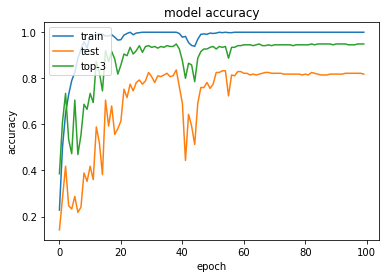

In [12]:
print('\nTest accuracy:', test_acc)
print('\nTraining time in seconds:', training_time) 
print(f"Test top 3 accuracy: {round(top_3_accuracy * 100, 2)}%")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_top-3-accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'top-3'], loc='upper left')
plt.show()